# 00: Data Preparation

*Before we can build a model, we need data to train it on.*

---

This notebook:
1. Loads the TinyStories dataset
2. Analyzes token frequencies using the GPT-2 tokenizer
3. Finds the minimum vocabulary that covers 99%+ of the corpus
4. Creates a truncated tokenizer with that vocabulary
5. Tokenizes and saves the dataset for use in later notebooks

By the end, we'll have a `tokenizer/` folder with our custom tokenizer and a `data/` folder with pre-tokenized training data.

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from tqdm.auto import tqdm
import json

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# We'll save things relative to this notebook
PROJECT_DIR = Path(".")
TOKENIZER_DIR = PROJECT_DIR / "tokenizer"
DATA_DIR = PROJECT_DIR / "data"

TOKENIZER_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

print("Ready.")

Ready.


---

## 1. Load TinyStories

TinyStories is a dataset of short children's stories generated by GPT-3.5 and GPT-4. It was created specifically for training small language models—the vocabulary is simple, the grammar is straightforward, and the stories are short.

Perfect for Lil Transformy.

In [ ]:
from datasets import load_dataset

# Load TinyStories (this may take a minute the first time)
print("Loading TinyStories...")
dataset = load_dataset("roneneldan/TinyStories")

print(f"\nDataset structure:")
print(dataset)

print(f"\nTraining examples: {len(dataset['train']):,}")
print(f"Validation examples: {len(dataset['validation']):,}")

# Note: TinyStories has ~6% of stories with mojibake (curly quotes rendered
# as â€œ instead of "). We're leaving this as-is—the model will learn
# the distribution of the data as it exists, warts and all.

In [ ]:
# Let's look at a few examples
print("=" * 60)
print("EXAMPLE STORIES")
print("=" * 60)

for i in range(3):
    story = dataset['train'][i]['text']
    print(f"\n--- Story {i+1} ---")
    print(story[:500] + "..." if len(story) > 500 else story)
    print()

---

## 2. Tokenize with GPT-2

GPT-2 uses Byte-Pair Encoding (BPE), which breaks text into subword tokens. Common words like "the" are single tokens; rare words get split into pieces.

The full GPT-2 vocabulary has ~50,257 tokens. But TinyStories only uses a fraction of them. Let's find out how many we actually need.

In [25]:
from transformers import GPT2TokenizerFast

# Load the standard GPT-2 tokenizer
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

print(f"GPT-2 vocabulary size: {len(gpt2_tokenizer):,}")
print(f"Example tokens:")
print(f"  'hello' -> {gpt2_tokenizer.encode('hello')}")
print(f"  'Hello' -> {gpt2_tokenizer.encode('Hello')}")
print(f"  ' the' -> {gpt2_tokenizer.encode(' the')}")
print(f"  'butterfly' -> {gpt2_tokenizer.encode('butterfly')}")

GPT-2 vocabulary size: 50,257
Example tokens:
  'hello' -> [31373]
  'Hello' -> [15496]
  ' the' -> [262]
  'butterfly' -> [4360, 353, 12254]


In [ ]:
# Count token frequencies across the training set
# (This takes a few minutes)

print("Counting token frequencies...")
token_counts = Counter()

for example in tqdm(dataset['train']):
    tokens = gpt2_tokenizer.encode(example['text'])
    token_counts.update(tokens)

print(f"\nTotal tokens in corpus: {sum(token_counts.values()):,}")
print(f"Unique tokens used: {len(token_counts):,}")
print(f"Unused GPT-2 tokens: {len(gpt2_tokenizer) - len(token_counts):,}")

In [ ]:
# What are the most common tokens?
print("Top 20 tokens:")
print("-" * 40)
for token_id, count in token_counts.most_common(20):
    token_str = gpt2_tokenizer.decode([token_id])
    print(f"  {token_id:5d}: {repr(token_str):15s} ({count:,})")

Top 20 tokens:
----------------------------------------
     13: '.'             (34,651,025)
    198: '\n'            (18,424,730)
    290: ' and'          (17,810,413)
     11: ','             (16,631,454)
    262: ' the'          (16,600,383)
    284: ' to'           (12,634,330)
    257: ' a'            (11,368,431)
    373: ' was'          (9,437,796)
    340: ' it'           (5,185,957)
    607: ' her'          (4,523,829)
   1375: ' She'          (4,459,340)
    679: ' He'           (4,270,530)
   1119: ' They'         (3,900,447)
    531: ' said'         (3,596,330)
    339: ' he'           (3,491,794)
    366: ' "'            (3,460,701)
    287: ' in'           (3,151,356)
    673: ' she'          (3,088,523)
    351: ' with'         (3,063,926)
    465: ' his'          (2,851,363)


---

## 3. Coverage Analysis

Here's the key question: **How many tokens do we need to cover the corpus?**

If we rank tokens by frequency, the top N tokens will cover some percentage of all token occurrences. We want to find the smallest N that gives us good coverage (99%+).

In [ ]:
# Calculate cumulative coverage
total_tokens = sum(token_counts.values())
sorted_counts = sorted(token_counts.values(), reverse=True)

cumulative = np.cumsum(sorted_counts) / total_tokens

# Find coverage at key thresholds
thresholds = [1024, 2048, 4096, 6144, 8192, 10000, 16384]

print("Coverage by vocabulary size:")
print("-" * 40)
for thresh in thresholds:
    if thresh <= len(cumulative):
        coverage = cumulative[thresh - 1] * 100
        print(f"  Top {thresh:,} tokens: {coverage:.2f}%")
    else:
        print(f"  Top {thresh:,} tokens: (exceeds unique token count)")

Coverage by vocabulary size:
----------------------------------------
  Top 1,024 tokens: 90.65%
  Top 2,048 tokens: 95.44%
  Top 4,096 tokens: 98.75%
  Top 6,144 tokens: 99.54%
  Top 8,192 tokens: 99.79%
  Top 10,000 tokens: 99.88%
  Top 16,384 tokens: 99.98%


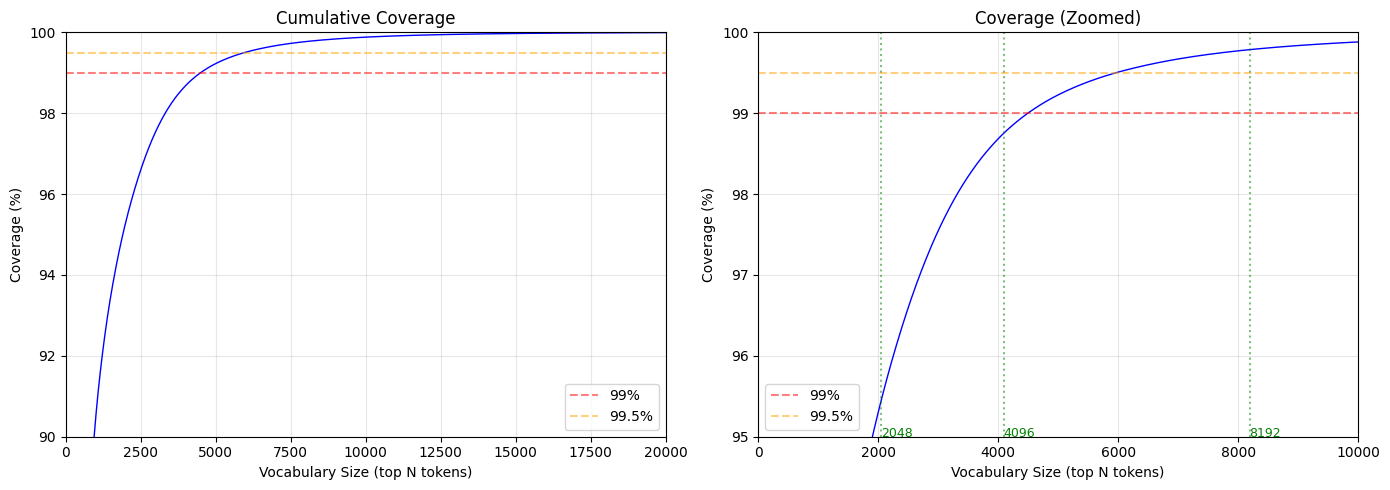

Saved: coverage_analysis.png


In [ ]:
# Visualize the coverage curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: full curve
ax1.plot(range(1, len(cumulative) + 1), cumulative * 100, 'b-', linewidth=1)
ax1.axhline(y=99, color='r', linestyle='--', alpha=0.5, label='99%')
ax1.axhline(y=99.5, color='orange', linestyle='--', alpha=0.5, label='99.5%')
ax1.set_xlabel('Vocabulary Size (top N tokens)')
ax1.set_ylabel('Coverage (%)')
ax1.set_title('Cumulative Coverage')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 20000)
ax1.set_ylim(90, 100)

# Right plot: zoom in on the knee
ax2.plot(range(1, min(10000, len(cumulative)) + 1), cumulative[:10000] * 100, 'b-', linewidth=1)
ax2.axhline(y=99, color='r', linestyle='--', alpha=0.5, label='99%')
ax2.axhline(y=99.5, color='orange', linestyle='--', alpha=0.5, label='99.5%')

# Mark key vocab sizes
for thresh in [2048, 4096, 8192]:
    if thresh <= len(cumulative):
        ax2.axvline(x=thresh, color='green', linestyle=':', alpha=0.5)
        ax2.annotate(f'{thresh}', xy=(thresh, 95), fontsize=9, color='green')

ax2.set_xlabel('Vocabulary Size (top N tokens)')
ax2.set_ylabel('Coverage (%)')
ax2.set_title('Coverage (Zoomed)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 10000)
ax2.set_ylim(95, 100)

plt.tight_layout()
plt.savefig('coverage_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("Saved: coverage_analysis.png")

In [ ]:
# Find the exact vocab sizes for key coverage thresholds
for target in [0.99, 0.995, 0.999]:
    idx = np.searchsorted(cumulative, target)
    print(f"  {target*100:.1f}% coverage requires {idx + 1:,} tokens")

  99.0% coverage requires 4,496 tokens
  99.5% coverage requires 5,963 tokens
  99.9% coverage requires 10,566 tokens


---

## 4. Choose Vocabulary Size

Based on the analysis above, we'll pick a vocabulary size. We want:
- **99%+ coverage** (so we rarely hit unknown tokens)
- **A nice round number** (power of 2 is aesthetically pleasing and sometimes helps with GPU memory alignment)
- **As small as reasonable** (smaller embedding matrix = faster training)

In [ ]:
# Based on the analysis, let's pick our vocabulary size
# (Adjust this after seeing the coverage numbers above)

VOCAB_SIZE = 4096  # 2^12 — adjust based on coverage analysis

# Verify coverage
coverage = cumulative[VOCAB_SIZE - 1] * 100
print(f"Chosen vocabulary size: {VOCAB_SIZE:,}")
print(f"Coverage: {coverage:.2f}%")
print(f"Uncovered tokens will map to <unk>")

Chosen vocabulary size: 4,096
Coverage: 98.75%
Uncovered tokens will map to <unk>


---

## 5. Build the Token Mapping

Now we create a mapping from GPT-2 token IDs to our compact vocabulary (0 to VOCAB_SIZE-1).

Special tokens:
- **0**: `<pad>` — padding token
- **1**: `<unk>` — unknown token (for anything outside our vocab)
- **2**: `<eos>` — end of sequence

Then tokens 3 through VOCAB_SIZE-1 are the most frequent GPT-2 tokens.

In [ ]:
# Special token IDs in our compact vocabulary
PAD_ID = 0
UNK_ID = 1
EOS_ID = 2
FIRST_REAL_TOKEN = 3

# Get the most frequent GPT-2 tokens (excluding any that conflict with our special tokens)
num_real_tokens = VOCAB_SIZE - FIRST_REAL_TOKEN
top_gpt2_tokens = [token_id for token_id, count in token_counts.most_common(num_real_tokens)]

# Build bidirectional mapping
gpt2_to_compact = {}
compact_to_gpt2 = {}

for i, gpt2_id in enumerate(top_gpt2_tokens):
    compact_id = i + FIRST_REAL_TOKEN
    gpt2_to_compact[gpt2_id] = compact_id
    compact_to_gpt2[compact_id] = gpt2_id

print(f"Mapping created:")
print(f"  Compact vocab size: {VOCAB_SIZE}")
print(f"  Special tokens: 0=<pad>, 1=<unk>, 2=<eos>")
print(f"  Real tokens: {FIRST_REAL_TOKEN} to {VOCAB_SIZE - 1}")
print(f"  GPT-2 tokens mapped: {len(gpt2_to_compact)}")

Mapping created:
  Compact vocab size: 4096
  Special tokens: 0=<pad>, 1=<unk>, 2=<eos>
  Real tokens: 3 to 4095
  GPT-2 tokens mapped: 4093


In [ ]:
# Test the mapping
test_text = "Once upon a time there was a little girl named Lily."
gpt2_tokens = gpt2_tokenizer.encode(test_text)
compact_tokens = [gpt2_to_compact.get(t, UNK_ID) for t in gpt2_tokens]

print(f"Test text: {test_text}")
print(f"GPT-2 tokens: {gpt2_tokens}")
print(f"Compact tokens: {compact_tokens}")
print(f"Unknown tokens: {compact_tokens.count(UNK_ID)}")

Test text: Once upon a time there was a little girl named Lily.
GPT-2 tokens: [7454, 2402, 257, 640, 612, 373, 257, 1310, 2576, 3706, 20037, 13]
Compact tokens: [58, 62, 9, 39, 41, 10, 9, 40, 63, 80, 29, 3]
Unknown tokens: 0


---

## 6. Build the Tokenizer Class

Let's wrap everything in a clean tokenizer class that we can save and reuse.

In [ ]:
class LilTokenizer:
    """
    A compact tokenizer for Lil Transformy.
    
    Wraps GPT-2 tokenizer but maps to a smaller vocabulary.
    """
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        
        # Special tokens
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        """Convert text to compact token IDs."""
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        """Convert compact token IDs back to text."""
        # Filter out special tokens and convert to GPT-2 IDs
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def __len__(self):
        return self.vocab_size
    
    def save(self, path):
        """Save tokenizer config to JSON."""
        config = {
            'vocab_size': self.vocab_size,
            'gpt2_to_compact': {str(k): v for k, v in self.gpt2_to_compact.items()},
            'compact_to_gpt2': {str(k): v for k, v in self.compact_to_gpt2.items()},
        }
        with open(path, 'w') as f:
            json.dump(config, f)
    
    @classmethod
    def load(cls, path):
        """Load tokenizer from JSON."""
        with open(path, 'r') as f:
            config = json.load(f)
        
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])


# Create and test our tokenizer
tokenizer = LilTokenizer(gpt2_to_compact, compact_to_gpt2, VOCAB_SIZE)

# Test round-trip
test_text = "Once upon a time there was a little girl named Lily."
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)

print(f"Original:  {test_text}")
print(f"Encoded:   {encoded}")
print(f"Decoded:   {decoded}")
print(f"Round-trip OK: {decoded.strip() == test_text}")

Original:  Once upon a time there was a little girl named Lily.
Encoded:   [58, 62, 9, 39, 41, 10, 9, 40, 63, 80, 29, 3, 2]
Decoded:   Once upon a time there was a little girl named Lily.
Round-trip OK: True


In [ ]:
# Save the tokenizer
tokenizer_path = TOKENIZER_DIR / "tokenizer.json"
tokenizer.save(tokenizer_path)
print(f"Saved tokenizer to: {tokenizer_path}")

# Verify it loads correctly
tokenizer_reloaded = LilTokenizer.load(tokenizer_path)
assert tokenizer_reloaded.encode(test_text) == encoded
print("Tokenizer reload verified.")

Saved tokenizer to: tokenizer/tokenizer.json
Tokenizer reload verified.


---

## 7. Tokenize the Dataset

Now we tokenize the entire training set and chunk it into fixed-length sequences for training.

We'll use a context length of 256 tokens (smaller than Duckling II's 512, since our early models won't benefit from long context anyway).

In [ ]:
# Parameters
CONTEXT_LENGTH = 256

print(f"Tokenizing dataset with context length {CONTEXT_LENGTH}...")

# Tokenize all stories and concatenate
all_tokens = []

for example in tqdm(dataset['train']):
    tokens = tokenizer.encode(example['text'], add_eos=True)
    all_tokens.extend(tokens)

print(f"\nTotal tokens: {len(all_tokens):,}")

# Chunk into sequences
num_sequences = len(all_tokens) // CONTEXT_LENGTH
all_tokens = all_tokens[:num_sequences * CONTEXT_LENGTH]  # Trim to exact multiple

# Reshape into sequences
sequences = np.array(all_tokens).reshape(num_sequences, CONTEXT_LENGTH)

print(f"Sequences: {sequences.shape[0]:,} x {sequences.shape[1]}")
print(f"Total tokens (after chunking): {sequences.size:,}")

In [ ]:
# Save as numpy file
data_path = DATA_DIR / "train_sequences.npy"
np.save(data_path, sequences)
print(f"Saved dataset to: {data_path}")
print(f"File size: {data_path.stat().st_size / 1e6:.1f} MB")

# Also save validation set (smaller)
val_tokens = []
for example in tqdm(dataset['validation'], desc="Tokenizing validation"):
    tokens = tokenizer.encode(example['text'], add_eos=True)
    val_tokens.extend(tokens)

num_val_sequences = len(val_tokens) // CONTEXT_LENGTH
val_tokens = val_tokens[:num_val_sequences * CONTEXT_LENGTH]
val_sequences = np.array(val_tokens).reshape(num_val_sequences, CONTEXT_LENGTH)

val_path = DATA_DIR / "val_sequences.npy"
np.save(val_path, val_sequences)
print(f"\nSaved validation to: {val_path}")
print(f"Validation sequences: {val_sequences.shape[0]:,}")

In [27]:
# Verify we can load and decode
loaded_sequences = np.load(data_path)
sample_sequence = loaded_sequences[0]

print("Sample sequence (decoded):")
print("-" * 60)
print(tokenizer.decode(sample_sequence.tolist()))
print("-" * 60)

Sample sequence (decoded):
------------------------------------------------------------
One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in

---

## Summary

We now have:

| File | Contents |
|------|----------|
| `tokenizer/tokenizer.json` | Our compact tokenizer config |
| `data/train_sequences.npy` | Tokenized training data, shape (N, 256) |
| `data/val_sequences.npy` | Tokenized validation data |

Every subsequent notebook will load these files and use them for training.

**Next up:** Notebook 01, where we build the simplest possible "language model"—a bag of words.

In [ ]:
# Final statistics
print("=" * 60)
print("DATA PREPARATION COMPLETE")
print("=" * 60)
print(f"\nVocabulary size: {VOCAB_SIZE:,}")
print(f"Context length: {CONTEXT_LENGTH}")
print(f"Training sequences: {sequences.shape[0]:,}")
print(f"Validation sequences: {val_sequences.shape[0]:,}")
print(f"Coverage: {coverage:.2f}%")
print(f"\nReady to build models!")

DATA PREPARATION COMPLETE

Vocabulary size: 4,096
Context length: 256
Training sequences: 1,851,532
Validation sequences: 18,616
Coverage: 98.75%

Ready to build models!
